# Regression

In [500]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

rnd=161223

data = pd.read_csv("https://raw.githubusercontent.com/JulienBastian/ConformalPrediction/master/dropout(regression).csv")[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (grade)',
       'Unemployment rate',
       'Inflation rate', 'GDP']].dropna()

data=data[data['Curricular units 1st sem (grade)']!=0]

features = ['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Unemployment rate',
       'Inflation rate', 'GDP']

X = data[features]
y = data['Curricular units 1st sem (grade)']
n = y.shape[0]


(array([100., 131., 220., 362., 489., 461., 389., 499., 372., 260., 168.,
        128.,  50.,  41.,  18.,  11.,   4.,   0.,   2.,   1.]),
 array([ 9.8    , 10.25375, 10.7075 , 11.16125, 11.615  , 12.06875,
        12.5225 , 12.97625, 13.43   , 13.88375, 14.3375 , 14.79125,
        15.245  , 15.69875, 16.1525 , 16.60625, 17.06   , 17.51375,
        17.9675 , 18.42125, 18.875  ]),
 <BarContainer object of 20 artists>)

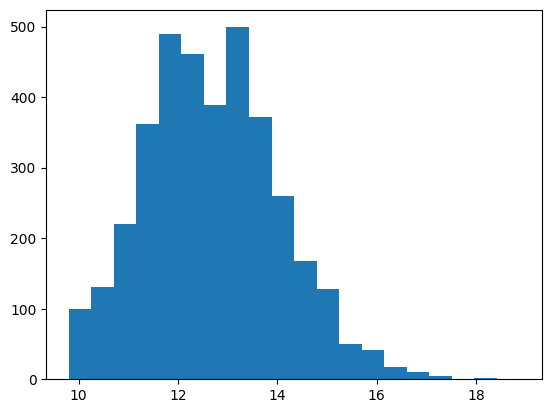

In [480]:
plt.hist(y, bins=20)

In [481]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rnd)

X_train_calib, X_calib, y_train_calib, y_calib = train_test_split(X_train, y_train, test_size=0.25, random_state=rnd)

ncalib= y_calib.shape[0]
ntrain=y_train_calib.shape[0]

AlphaCorrector = (ncalib+1)/ncalib

## Algorithms



In [482]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.ensemble import RandomForestClassifier

Quantile Regression

In [483]:
def QuantileRegressionCoverage(X_train, y_train, X_test, y_test, alpha):
  qr_down = QuantileRegressor(quantile=alpha/2, alpha = 0, solver='highs').fit(X_train, y_train)
  qr_up = QuantileRegressor(quantile=1-alpha/2, alpha = 0, solver='highs').fit(X_train, y_train)

  down = qr_down.predict(X_test)
  up = qr_up.predict(X_test)
  coverage_percentage = np.mean([(y_test >= down) & (y_test <= up)])

  return coverage_percentage

Split Conformal Prediction

In [484]:
def LinearRegression_SplitConformal_Coverage(X_train, y_train, X_test, y_test, X_calib, y_calib, expected_coverage, AlphaCorrector):
  LinReg = LinearRegression()
  LinReg= LinReg.fit(X_train, y_train)

  ypred_calib = LinReg.predict(X_calib)
  ConformityScore = np.abs(ypred_calib - y_calib)
  ConformalQuantiles = np.quantile(ConformityScore, expected_coverage*AlphaCorrector)

  coverages=[]

  ypred_test = LinReg.predict(X_test)
  for quantile in ConformalQuantiles:
    down = ypred_test - quantile
    up = ypred_test + quantile
    coverages.append(np.mean([(y_test >= down) & (y_test <= up)]))

  return coverages

JackKnife +

In [485]:
def LinearRegression_JKplus_Coverage(X_train, y_train, X_test, y_test, expected_coverage, idx_attribute=[]):
  ScorePlus = []
  ScoreMinus = []
  alphas=1-expected_coverage

  for i in X_train.index:
    LinReg = LinearRegression().fit(X_train.drop(i), y_train.drop(i))
    AbsoluteDif = np.absolute(LinReg.predict([X_train.loc[i]]) - y_train.loc[i])
    ypred = LinReg.predict(X_test)
    ScorePlus.append(ypred + AbsoluteDif)
    ScoreMinus.append(ypred - AbsoluteDif)
  coverages = []

  for alpha in alphas:
    down = []
    up = []

    if len(idx_attribute)==0:
      for i in range(np.array(ScorePlus).shape[1]):
        up.append(np.quantile(np.array(ScorePlus)[:, i], 1- alpha))
        down.append(np.quantile(np.array(ScoreMinus)[:, i], alpha))

      coverages.append(np.mean([(y_test >= down) & (y_test <= up)]))

    else:
      for i in idx_attribute:
        up.append(np.quantile(np.array(ScorePlus)[:, idx_attribute], 1- alpha))
        down.append(np.quantile(np.array(ScoreMinus)[:, idx_attribute], alpha))

      coverages.append(np.mean([(y_test[idx_attribute] >= down) & (y_test[idx_attribute] <= up)]))

  return coverages

## Training

In [486]:
alpha_list=[.1,.075,.05,.025,.01]
expected_coverage=1-np.array(alpha_list)

In [488]:
Quantile_Coverages=[]
for alpha in alpha_list:
  Quantile_Coverages.append(QuantileRegressionCoverage(X_train, y_train, X_test, y_test, alpha=alpha))

LinearJK_Coverages=LinearRegression_JKplus_Coverage(X_train, y_train, X_test, y_test, expected_coverage)

LinearSplit_Coverages=LinearRegression_SplitConformal_Coverage(X_train_calib, y_train_calib, X_test, y_test, X_calib, y_calib, expected_coverage, AlphaCorrector)

## Results

### Global Results

<function matplotlib.pyplot.show(close=None, block=None)>

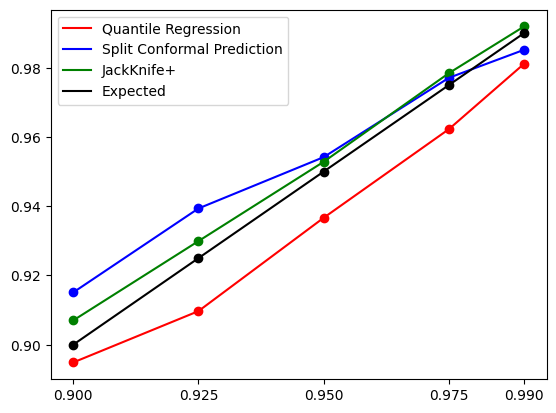

In [489]:
plt.scatter(expected_coverage, Quantile_Coverages, color="red")
plt.scatter(expected_coverage, LinearSplit_Coverages, color="blue")
plt.scatter(expected_coverage, LinearJK_Coverages, color="green")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, Quantile_Coverages, color="red")
p2=plt.plot(expected_coverage, LinearSplit_Coverages, color="blue")
p3=plt.plot(expected_coverage, LinearJK_Coverages, color="green")
p4=plt.plot(expected_coverage, expected_coverage, color="black")

plt.xticks(expected_coverage)

plt.legend(p1 + p2 + p3 +p4, ['Quantile Regression', 'Split Conformal Prediction', 'JackKnife+', 'Expected'])

plt.show

### Fairness Criticized Results

Gender differences

<function matplotlib.pyplot.show(close=None, block=None)>

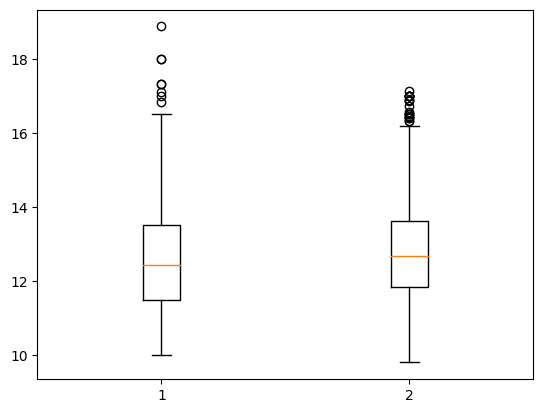

In [490]:
plt.boxplot([y[X["Gender"]==1], y[X["Gender"]==0]])
plt.show

In [491]:
#by gender
alpha_list=[.1,.075,.05,.025,.01]
expected_coverage=1-np.array(alpha_list)

X_test=X_test.reset_index(drop=True)
y_test=np.array(list(y_test))

X_male=X_test[X_test["Gender"]==1]
y_male=y_test[X_test["Gender"]==1]

X_female=X_test[X_test["Gender"]==0]
y_female=y_test[X_test["Gender"]==0]

Quantile_Coverages_male=[]
for alpha in alpha_list:
  Quantile_Coverages_male.append(QuantileRegressionCoverage(X_train, y_train, X_male, y_male, alpha=alpha))

LinearJK_Coverages_male=LinearRegression_JKplus_Coverage(X_train, y_train, X_test, y_test, expected_coverage, idx_attribute=X_male.index)

LinearSplit_Coverages_male=LinearRegression_SplitConformal_Coverage(X_train_calib, y_train_calib, X_male, y_male, X_calib, y_calib, expected_coverage, AlphaCorrector)


Quantile_Coverages_female=[]
for alpha in alpha_list:
  Quantile_Coverages_female.append(QuantileRegressionCoverage(X_train, y_train, X_female, y_female, alpha=alpha))

LinearJK_Coverages_female=LinearRegression_JKplus_Coverage(X_train, y_train, X_test, y_test, expected_coverage, idx_attribute=X_female.index)

LinearSplit_Coverages_female=LinearRegression_SplitConformal_Coverage(X_train_calib, y_train_calib, X_female, y_female, X_calib, y_calib, expected_coverage, AlphaCorrector)

In [ ]:
plt.scatter(expected_coverage, Quantile_Coverages_female, color="red")
plt.scatter(expected_coverage, Quantile_Coverages_male, color="red")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, Quantile_Coverages_female, color="red", linestyle="--")
p2=plt.plot(expected_coverage, Quantile_Coverages_male, color="red", linestyle=":")
p3=plt.plot(expected_coverage, expected_coverage, color="black" )

plt.xticks(expected_coverage)

plt.legend(p1 + p2 + p3, ['Quantile Regression Women', 'Quantile Regression Women', 'Expected'])


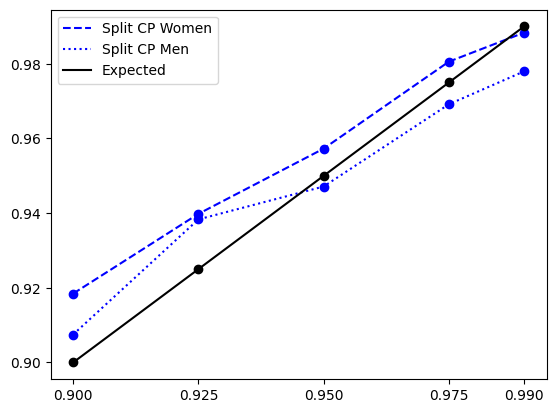

In [506]:
plt.scatter(expected_coverage, LinearSplit_Coverages_female, color="blue")
plt.scatter(expected_coverage, LinearSplit_Coverages_male, color="blue")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, LinearSplit_Coverages_female, color="blue", linestyle="--")
p2=plt.plot(expected_coverage, LinearSplit_Coverages_male, color="blue", linestyle=":")
p3=plt.plot(expected_coverage, expected_coverage, color="black" )

plt.xticks(expected_coverage)

plt.legend(p1 + p2 + p3, ['Split CP Women', 'Split CP Men', 'Expected'])

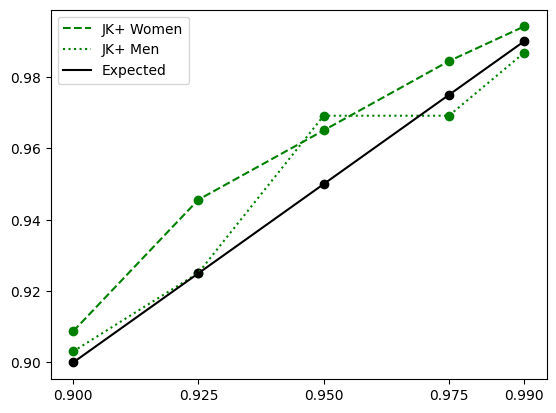

In [501]:
plt.scatter(expected_coverage, LinearJK_Coverages_female, color="green")
plt.scatter(expected_coverage, LinearJK_Coverages_male, color="green")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, LinearJK_Coverages_female, color="green", linestyle="--")
p2=plt.plot(expected_coverage, LinearJK_Coverages_male, color="green", linestyle=":")
p3=plt.plot(expected_coverage, expected_coverage, color="black" )

plt.xticks(expected_coverage)

plt.legend(p1 + p2 + p3, ['JK+ Women', 'JK+ Men', 'Expected'])

Debtor or not

In [493]:
X_debt=X_test[X_test["Debtor"]==1]
y_debt=y_test[X_test["Debtor"]==1]

X_nodebt=X_test[X_test["Debtor"]==0]
y_nodebt=y_test[X_test["Debtor"]==0]

Quantile_Coverages_debt=[]
for alpha in alpha_list:
  Quantile_Coverages_debt.append(QuantileRegressionCoverage(X_train, y_train, X_debt, y_debt, alpha=alpha))

LinearJK_Coverages_debt=LinearRegression_JKplus_Coverage(X_train, y_train, X_test, y_test, expected_coverage, idx_attribute=X_debt.index)

LinearSplit_Coverages_debt=LinearRegression_SplitConformal_Coverage(X_train_calib, y_train_calib, X_debt, y_debt, X_calib, y_calib, expected_coverage, AlphaCorrector)


Quantile_Coverages_nodebt=[]
for alpha in alpha_list:
  Quantile_Coverages_nodebt.append(QuantileRegressionCoverage(X_train, y_train, X_nodebt, y_nodebt, alpha=alpha))

LinearJK_Coverages_nodebt=LinearRegression_JKplus_Coverage(X_train, y_train, X_test, y_test, expected_coverage, idx_attribute=X_nodebt.index)

LinearSplit_Coverages_nodebt=LinearRegression_SplitConformal_Coverage(X_train_calib, y_train_calib, X_nodebt, y_nodebt, X_calib, y_calib, expected_coverage, AlphaCorrector)

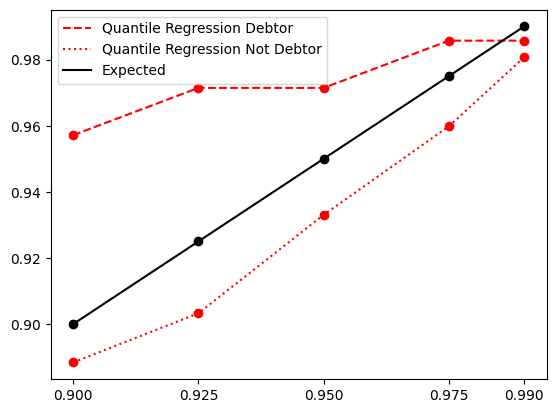

In [503]:
plt.scatter(expected_coverage, Quantile_Coverages_debt, color="red")
plt.scatter(expected_coverage, Quantile_Coverages_nodebt, color="red")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, Quantile_Coverages_debt, color="red", linestyle="--")
p2=plt.plot(expected_coverage, Quantile_Coverages_nodebt, color="red", linestyle=":")
p3=plt.plot(expected_coverage, expected_coverage, color="black" )

plt.xticks(expected_coverage)

plt.legend(p1 + p2 + p3, ['Quantile Regression Debtor', 'Quantile Regression Not Debtor', 'Expected'])


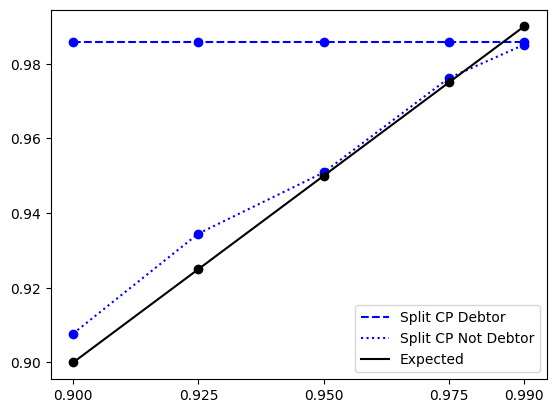

In [504]:
plt.scatter(expected_coverage, LinearSplit_Coverages_debt, color="blue")
plt.scatter(expected_coverage, LinearSplit_Coverages_nodebt, color="blue")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, LinearSplit_Coverages_debt, color="blue", linestyle="--")
p2=plt.plot(expected_coverage, LinearSplit_Coverages_nodebt, color="blue", linestyle=":")
p3=plt.plot(expected_coverage, expected_coverage, color="black" )

plt.xticks(expected_coverage)

plt.legend(p1 + p2 + p3, ['Split CP Debtor', 'Split CP Not Debtor', 'Expected'])

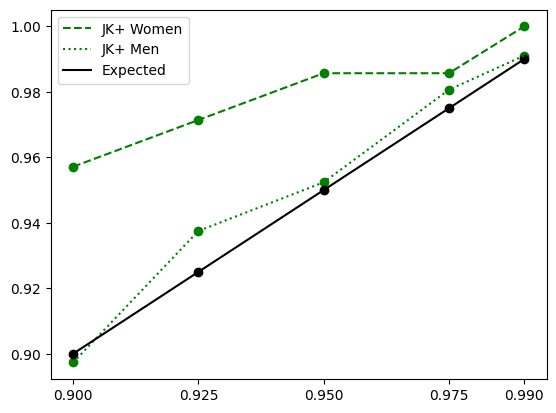

In [505]:
plt.scatter(expected_coverage, LinearJK_Coverages_debt, color="green")
plt.scatter(expected_coverage, LinearJK_Coverages_nodebt, color="green")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, LinearJK_Coverages_debt, color="green", linestyle="--")
p2=plt.plot(expected_coverage, LinearJK_Coverages_nodebt, color="green", linestyle=":")
p3=plt.plot(expected_coverage, expected_coverage, color="black" )

plt.xticks(expected_coverage)

plt.legend(p1 + p2 + p3, ['JK+ Women', 'JK+ Men', 'Expected'])

# Classification

In [511]:
from sklearn.preprocessing import LabelEncoder

data2 = pd.read_csv("https://raw.githubusercontent.com/JulienBastian/ConformalPrediction/master/alcohol.csv")

data2.columns

data2.dtypes["school"]=="object" #dtype('O') c'est object

True

In [514]:
le = LabelEncoder()

for col in data2.columns :
  if data2.dtypes[col]=="object":
    print(data2[col].value_counts())
    label = le.fit_transform(data2[col])
    print(pd.DataFrame(label).value_counts())

    data2[col] = label

In [515]:
X=data2[['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3']]
y=data2['Dalc']

In [516]:
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rnd)

X_train_calib, X_calib, y_train_calib, y_calib = train_test_split(X_train, y_train, test_size=0.3, random_state=rnd)

ncalib= y_calib.shape[0]
ntrain=y_train_calib.shape[0]

AlphaCorrector = (ncalib+1)/ncalib

## Algorithm

In [517]:
def score_classif(y_prob, y, classes):
  n = len(y)
  prob_y = np.array([y_prob[i][y[i] == classes] for i in range(n)])
  score = 1 - prob_y
  return score

In [518]:
def averageLen(lst):
    lengths = [len(i) for i in lst]
    return 0 if len(lengths) == 0 else (float(sum(lengths)) / len(lengths))

## Training

In [519]:
modele = RandomForestClassifier(random_state=rnd).fit(X_train_calib, y_train_calib)
y_hat_calib = modele.predict_proba(X_calib)
classes = modele.classes_

In [520]:
# score sur les données de calibration
S1 = score_classif(y_hat_calib, y_calib, classes)

## Results

### Global Results

In [234]:
from matplotlib.patches import Rectangle

(array([0.69491525, 0.18644068, 0.06625578, 0.02619414, 0.02619414]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

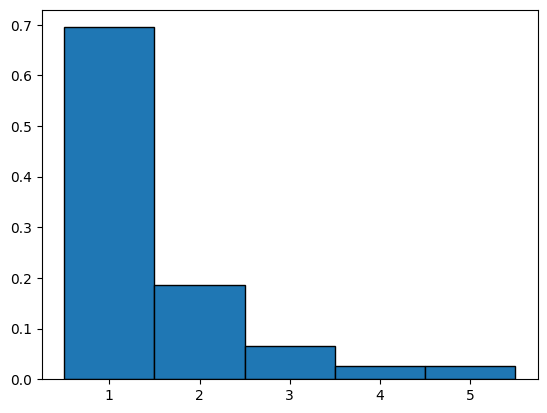

In [455]:
plt.hist(y, density=True, ec="k",bins=range(1,7), align="left")

In [521]:
y_hat_test = modele.predict_proba(X_test)

s1 = 1 - y_hat_test

SplitCoverages=[]
IntervalLength=[]
for coverage in expected_coverage:
  q_S1 = np.quantile(S1, coverage*AlphaCorrector)
  y_conformal = [list(classes[s1[i] < q_S1]) for i in range(len(y_hat_test))]
  IntervalLength.append(averageLen(y_conformal))
  SplitCoverages.append(np.mean([y_test[i] in y_conformal[i] for i in range(len(y_test))]))

<function matplotlib.pyplot.show(close=None, block=None)>

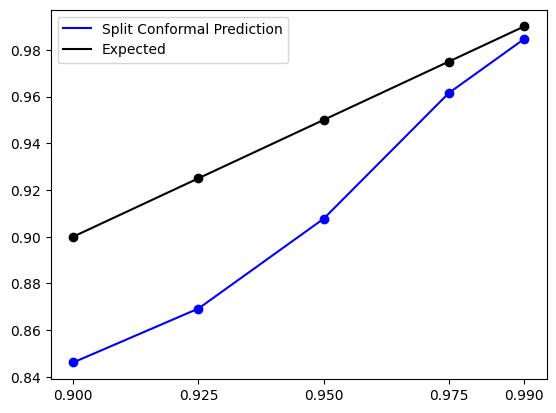

In [522]:
plt.scatter(expected_coverage, SplitCoverages, color="blue")
plt.scatter(expected_coverage, expected_coverage, color="black")

p1=plt.plot(expected_coverage, SplitCoverages, color="blue")
p2=plt.plot(expected_coverage, expected_coverage, color="black")

plt.xticks(expected_coverage)

plt.legend(p1 + p2, ['Split Conformal Prediction', 'Expected'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

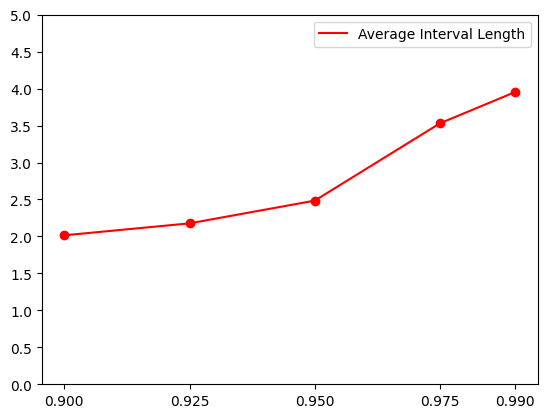

In [523]:
plt.scatter(expected_coverage, IntervalLength, color="red")

p1=plt.plot(expected_coverage, IntervalLength, color="red")

plt.xticks(expected_coverage)
plt.yticks(np.arange(0,5.5, 0.5))

plt.legend(p1, ['Average Interval Length'])

plt.show

### Fairness Criticized Results

Gender differences

<function matplotlib.pyplot.show(close=None, block=None)>

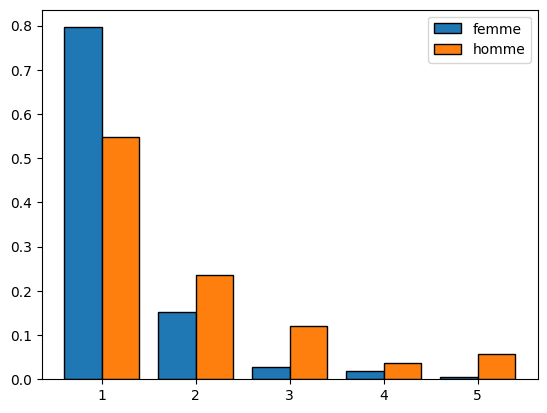

In [261]:
plt.hist([y[X["sex"]==0], y[X["sex"]==1]], density=True, ec="k",bins=range(1,7), align="left")

colors = ["C0", "C1"]
plt.xticks(np.arange(1.,5.1))
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
labels = ["Women", "Men"]

plt.legend(handles, labels)
plt.show

In [524]:
y_test_femme=y_test[X_test["sex"]==0]
ypred_test_femme = modele.predict_proba(X_test[X_test["sex"]==0])

s1 = 1 - ypred_test_femme

SplitCoveragesFemme=[]
IntervalLengthFemme=[]
for coverage in expected_coverage:
  q_S1 = np.quantile(S1, coverage*AlphaCorrector)
  y_conformal = [list(classes[s1[i] < q_S1]) for i in range(len(ypred_test_femme))]
  IntervalLengthFemme.append(averageLen(y_conformal))
  SplitCoveragesFemme.append(np.mean([y_test_femme[i] in y_conformal[i] for i in range(len(y_test_femme))]))

In [525]:
y_test_homme=y_test[X_test["sex"]==1]
ypred_test_homme = modele.predict_proba(X_test[X_test["sex"]==1])

s1 = 1 - ypred_test_homme

SplitCoveragesHomme=[]
IntervalLengthHomme=[]
for coverage in expected_coverage:
  q_S1 = np.quantile(S1, coverage*AlphaCorrector)
  y_conformal = [list(classes[s1[i] < q_S1]) for i in range(len(ypred_test_homme))]
  IntervalLengthHomme.append(averageLen(y_conformal))
  SplitCoveragesHomme.append(np.mean([y_test_homme[i] in y_conformal[i] for i in range(len(y_test_homme))]))

<function matplotlib.pyplot.show(close=None, block=None)>

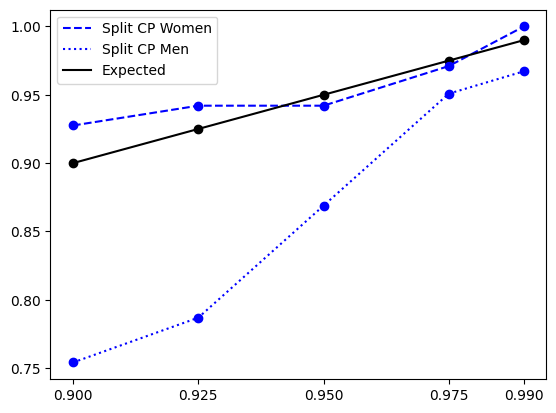

In [529]:
plt.scatter(expected_coverage, expected_coverage, color="black")
plt.scatter(expected_coverage, SplitCoveragesFemme, color="blue")
plt.scatter(expected_coverage, SplitCoveragesHomme, color="blue")

p1=plt.plot(expected_coverage, SplitCoveragesFemme, color="blue", linestyle="--")
p2=plt.plot(expected_coverage, SplitCoveragesHomme, color="blue", linestyle=":")
p3=plt.plot(expected_coverage, expected_coverage, color="black")

plt.xticks(expected_coverage)

plt.legend(p1 + p2 +p3 + p4, ['Split CP Women', 'Split CP Men', 'Expected'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

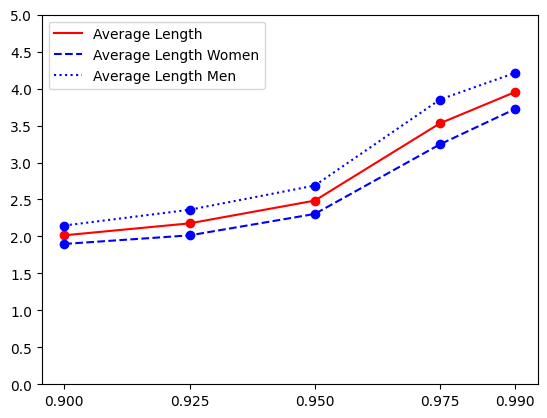

In [531]:
plt.scatter(expected_coverage, IntervalLength, color="red")
plt.scatter(expected_coverage, IntervalLengthFemme, color="blue")
plt.scatter(expected_coverage, IntervalLengthHomme, color="blue")

p1=plt.plot(expected_coverage, IntervalLength, color="red")
p2=plt.plot(expected_coverage, IntervalLengthFemme, color="blue", linestyle="--")
p3=plt.plot(expected_coverage, IntervalLengthHomme, color="blue", linestyle=":")

plt.xticks(expected_coverage)
plt.yticks(np.arange(0,5.5, 0.5))

plt.legend(p1 + p2 +p3, ['Average Length', 'Average Length Women', 'Average Length Men'])

plt.show

Economic disparities (additionnal paid classes)

<function matplotlib.pyplot.show(close=None, block=None)>

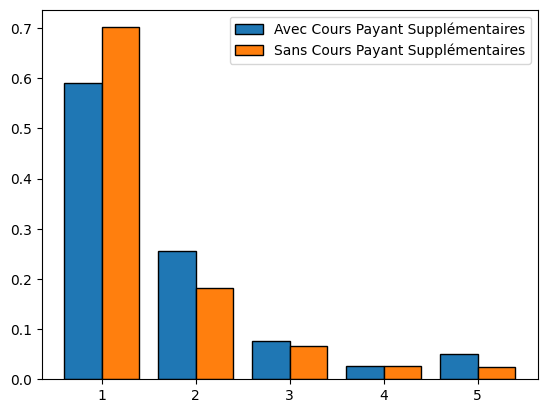

In [478]:
plt.hist([y[X["paid"]==1], y[X["paid"]==0]], density=True, ec="k",bins=range(1,7), align="left")#1 veut dire paid classes en plus

colors = ["C0", "C1"]
plt.xticks(np.arange(1.,5.1))
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
labels = ["Paid Classes", "No Paid Classes"]

plt.legend(handles, labels)
plt.show

In [532]:
y_test_paid=y_test[X_test["paid"]==1]
ypred_test_paid = modele.predict_proba(X_test[X_test["paid"]==1])

s1 = 1 - ypred_test_paid

SplitCoveragesPaid=[]
IntervalLengthPaid=[]
for coverage in expected_coverage:
  q_S1 = np.quantile(S1, coverage*AlphaCorrector)
  y_conformal = [list(classes[s1[i] < q_S1]) for i in range(len(ypred_test_paid))]
  IntervalLengthPaid.append(averageLen(y_conformal))
  SplitCoveragesPaid.append(np.mean([y_test_paid[i] in y_conformal[i] for i in range(len(y_test_paid))]))

In [533]:
y_test_notpaid=y_test[X_test["paid"]==0]
ypred_test_notpaid = modele.predict_proba(X_test[X_test["paid"]==0])

s1 = 1 - ypred_test_notpaid

SplitCoveragesNotPaid=[]
IntervalLengthNotPaid=[]
for coverage in expected_coverage:
  q_S1 = np.quantile(S1, coverage*AlphaCorrector)
  y_conformal = [list(classes[s1[i] < q_S1]) for i in range(len(ypred_test_notpaid))]
  IntervalLengthNotPaid.append(averageLen(y_conformal))
  SplitCoveragesNotPaid.append(np.mean([y_test_notpaid[i] in y_conformal[i] for i in range(len(y_test_notpaid))]))

<function matplotlib.pyplot.show(close=None, block=None)>

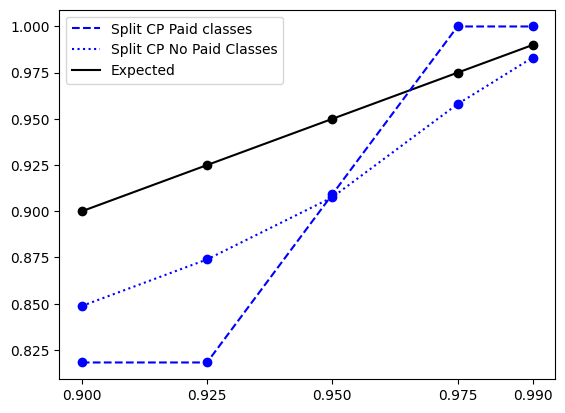

In [536]:
plt.scatter(expected_coverage, expected_coverage, color="black")
plt.scatter(expected_coverage, SplitCoveragesPaid, color="blue")
plt.scatter(expected_coverage, SplitCoveragesNotPaid, color="blue")

p3=plt.plot(expected_coverage, expected_coverage, color="black")
p1=plt.plot(expected_coverage, SplitCoveragesPaid, color="blue", linestyle="--")
p2=plt.plot(expected_coverage, SplitCoveragesNotPaid, color="blue", linestyle=":")

plt.xticks(expected_coverage)

plt.legend(p1 + p2 +p3, ['Split CP Paid classes', 'Split CP No Paid Classes', 'Expected'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

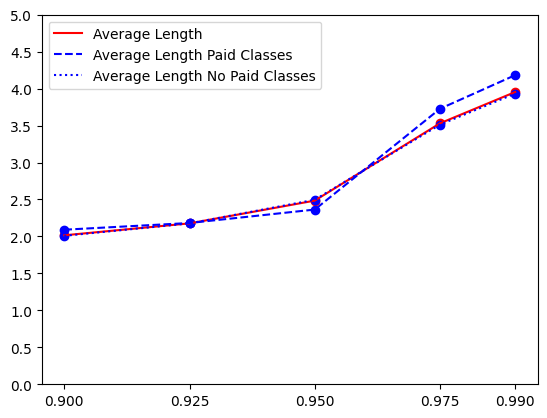

In [537]:
plt.scatter(expected_coverage, IntervalLength, color="red")
plt.scatter(expected_coverage, IntervalLengthPaid, color="blue")
plt.scatter(expected_coverage, IntervalLengthNotPaid, color="blue")

p1=plt.plot(expected_coverage, IntervalLength, color="red")
p2=plt.plot(expected_coverage, IntervalLengthPaid, color="blue", linestyle="--")
p3=plt.plot(expected_coverage, IntervalLengthNotPaid, color="blue", linestyle=":")

plt.xticks(expected_coverage)
plt.yticks(np.arange(0,5.5, 0.5))

plt.legend(p1 + p2 +p3, ['Average Length', 'Average Length Paid Classes', 'Average Length No Paid Classes'])

plt.show